# Introduction:
 Based on part of the paper: 
<br>"Pediatric Bone Age Assessment Using Deep Convolutional Neural Networks" 
<br>by Vladimir Iglovikov, Alexander Rakhlin, Alexandr Kalinin, and Alexey Shvets
<br>Create "passport images" pre-processing for hand scans

In [102]:
import os
import sys
import shutil
import pickle
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage import img_as_ubyte

from keras.models import Model, load_model, Sequential, model_from_json
from keras.layers import Input, BatchNormalization, Activation
from keras.layers.core import Dropout, Lambda, Flatten, Dense
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras import optimizers
from keras.callbacks import EarlyStopping

import imgaug as ia
from imgaug import augmenters as iaa

sys.path.append(r'C:\Users\nimro\Documents\Python Scripts')
import img_utils

%matplotlib inline

# Paths and Constants

In [3]:
# Constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
VAL_SPLIT = 0.15
ANNOTATED_SIZE = 400
VAL_SIZE = int(ANNOTATED_SIZE * VAL_SPLIT) + 1 # to match sklearn train_test_split function with sizes
TRAIN_SIZE = ANNOTATED_SIZE - VAL_SIZE
# Paths
TRAIN_PATH = r'C:\Users\nimro\Documents\Data\rsna_bone_age\boneage-training-dataset'
MASK_PATH = r'C:\Users\nimro\Documents\Data\rsna_bone_age\masks'
TEST_PATH = r'C:\Users\nimro\Documents\Data\rsna_bone_age\boneage-test-dataset'
REG_PATH = r'C:\Users\nimro\Documents\Data\rsna_bone_age\reg'
SEG_PATH = r'C:\Users\nimro\Documents\Data\rsna_bone_age\seg'

# Arrays decleration

In [4]:
train_filenames = os.listdir(TRAIN_PATH)
random_filenames = np.random.choice(train_filenames, ANNOTATED_SIZE, replace=False)
Y_train = np.zeros((ANNOTATED_SIZE, 6), dtype=np.float32)
X_regs = np.zeros((ANNOTATED_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
X_train = np.zeros((ANNOTATED_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_names = np.zeros(ANNOTATED_SIZE, dtype=np.int32)
X_train_after_split = np.zeros((TRAIN_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train_after_split = np.zeros((TRAIN_SIZE, 6), dtype=np.float32)
X_val = np.zeros((VAL_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_val = np.zeros((VAL_SIZE, 6), dtype=np.float32)
X_masks = np.zeros((ANNOTATED_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# Data Exploration

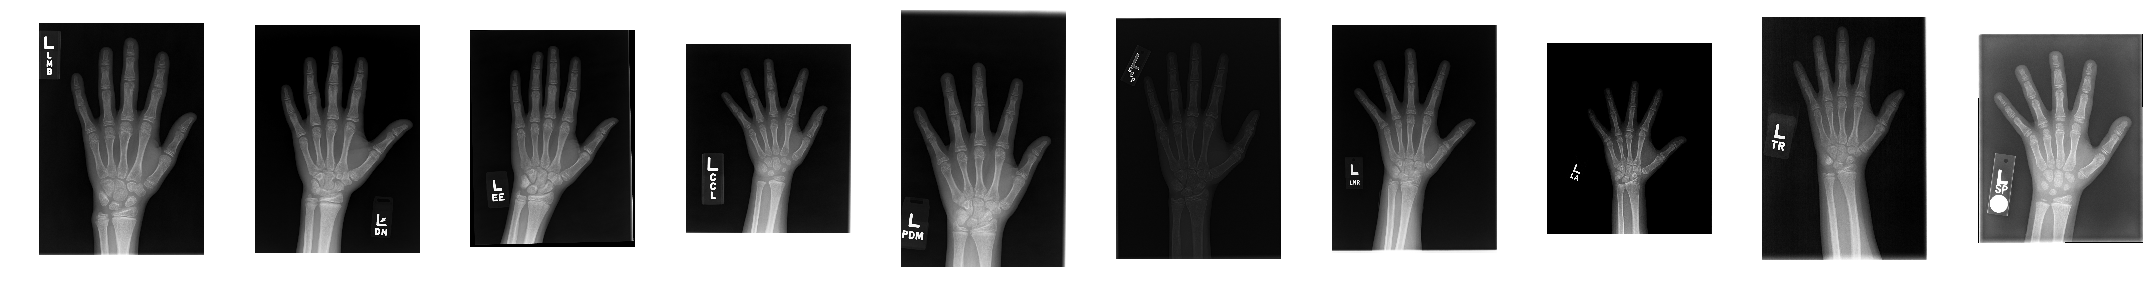

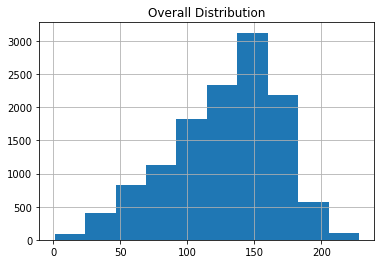

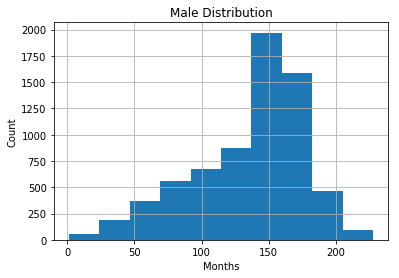

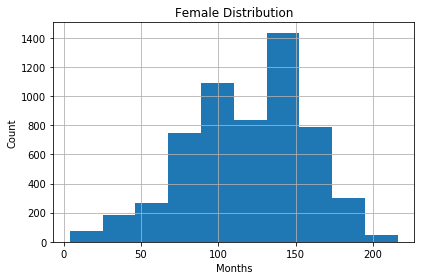

In [5]:
# First, let's take a look on some images
img_utils.showRandomDataFromFolder(TRAIN_PATH)

dfTrain = pd.read_csv(r'C:\Users\nimro\Documents\Data\rsna_bone_age\boneage-training-dataset.csv')
# Overall age distribution
plt.figure()
dfTrain['boneage'].hist()
plt.title('Overall Distribution')
# Distribution by gender
dfTrainMale = dfTrain[dfTrain['male'] == True]
dfTrainFemale = dfTrain[dfTrain['male'] == False]

plt.figure()
dfTrainMale['boneage'].hist()
plt.title('Male Distribution')
plt.xlabel('Months')
plt.ylabel('Count')
plt.figure()
dfTrainFemale['boneage'].hist()
plt.title('Female Distribution')
plt.xlabel('Months')
plt.ylabel('Count')
plt.tight_layout()


* All Images are in high-resultion (1500x1500) - for CPU have to resize top 128x128
* Normalize the data can help the regressor
* Important augmentations: 
    * fliplr
    * rotation
    * translation
<br>consider augment on image colors 

# Image Annotation Phase
Since the data for this specific task is not ready - manual annotation is needed.<br>
In this section OpenCV GUI will randomly sample images from the data set, resize it and let the user annotate the image.
<br>Annotation is done by double clicking 3 key-points on the hand: thumb, middle finger and the base of the hand.
<br>the cordinates grouped and at the end saved to file for further use.

In [ ]:
"""Annotation phase"""
thumb_coordinates = []
middle_finger_coordinates = []
base_coordinates = []
count = 0

def click_and_mark(event, x, y, flags, params):
    global thumb_coordinates, middle_finger_coordinates, base_coordinates
    global count
    if event == cv2.EVENT_LBUTTONDBLCLK: 
        if count % 3 == 0:
            thumb_coordinates.append((x,y))                                        
        elif count % 3 == 1:
            middle_finger_coordinates.append((x,y))                
        elif count % 3 == 2:
            base_coordinates.append((x,y))
                
        count+=1
                
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_and_mark)

for n, img_ in enumerate(random_filenames):    
    print('Iteration #' + str(n))
    fullPath = os.path.join(TRAIN_PATH, img_)
    img = np.expand_dims(imread(fullPath)[:,:], axis=2)    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)    
    img /= 255
    img_clone = img.copy()
    X_train[n, :, : , :] = img
    shutil.copy(fullPath, os.path.join(REG_PATH,img_))
    
    #annotate 3 locations
    thumb_coordinates = []
    middle_finger_coordinates = []
    base_coordinates = []
    while True:
        # display the image and wait for a keypress
        cv2.imshow("image", img)
        key = cv2.waitKey(1) & 0xFF 
        # if the 'c' key is pressed, break from the loop
        if key == ord("c"):
            break                 
    try:  
        srcPts = np.concatenate([thumb_coordinates, middle_finger_coordinates, base_coordinates], axis=0).astype(np.float32)
        Y_train[n] = srcPts.reshape(6)        
        base, ext = os.path.splitext(img_)
        Y_names[n] = int(base)
        print(Y_names[n])
        print(Y_train[n])     
        
    except:
        print("error in calc transformation")
    
cv2.destroyAllWindows()
# save annotation to file
np.savetxt(os.path.join(REG_PATH,'train_coordinates_example.csv'), np.concatenate((np.expand_dims(Y_names,1),Y_train), axis=1), delimiter=',')

Load Annotations from file and draw histogram for each coordinate - For Augmentation usage

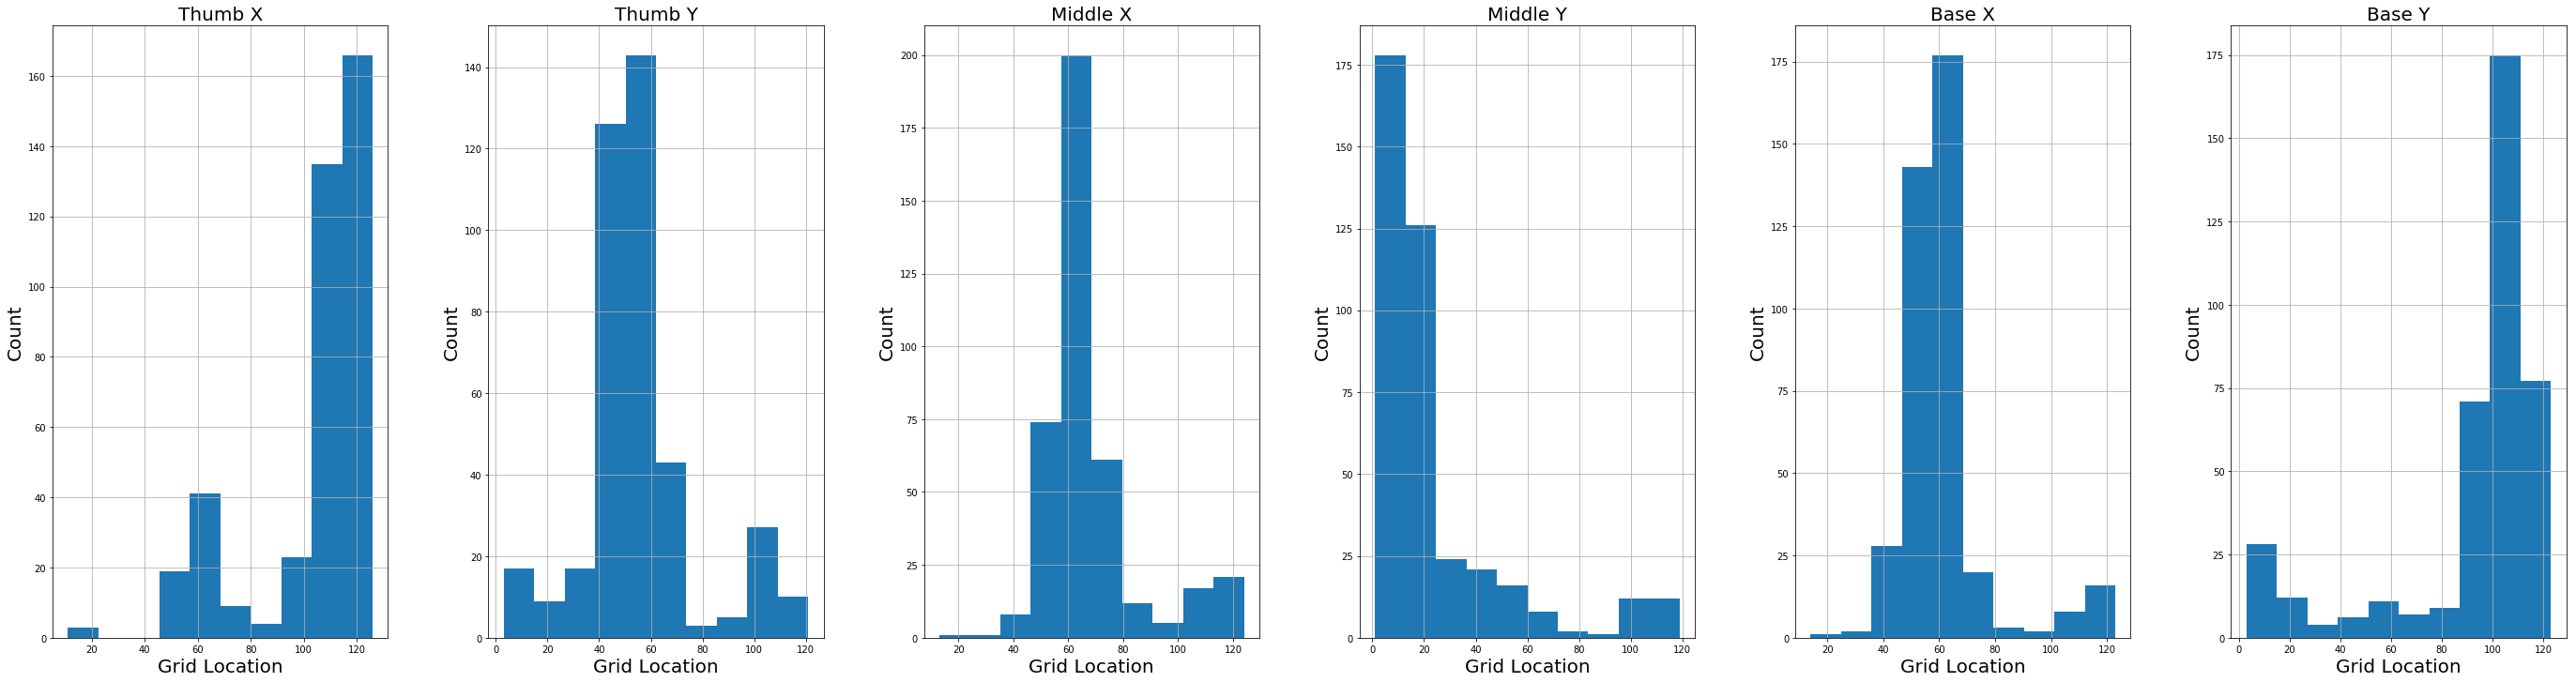

In [6]:
#load annotations from file
res = np.genfromtxt(os.path.join(REG_PATH,'train_coordinates.csv'), delimiter=',')
loaded_train_data = res[:,1:]
dfCoordiantes = pd.DataFrame(loaded_train_data)
titles = ['Thumb X', 'Thumb Y', 'Middle X', 'Middle Y', 'Base X', 'Base Y']
fig, axes = plt.subplots(1, len(dfCoordiantes.columns), figsize=(48, 12))
for col, axis in zip(dfCoordiantes.columns, axes):    
    dfCoordiantes.hist(column = col, ax=axis)
    axis.set_title(titles[col], fontsize=20)
    axis.set_xlabel('Grid Location', fontsize=20)    
    axis.set_ylabel('Count', fontsize=20)
    

# CNN Model

In [106]:
"""Build CNN model for perform geometric transformation regression"""

def createModel(dropRate=0.1, doPlot=True):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inputs)    
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)    
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)    
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)    
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    x = Flatten()(x)
    x = Dropout(5*dropRate)(x)
    outputs = Dense(6)(x)

    model = Model(inputs=[inputs], outputs=[outputs])    
    Optimizer = optimizers.adam()
    loss = 'mean_squared_error'
    metrics = ['mse']

    model.compile(optimizer=Optimizer, loss=loss, metrics=metrics)
    if doPlot:
        model.summary()
    return model

# Pre-Process Phase

In [35]:
"""Train - Validation split"""
for n, annotate_img_ in enumerate (res[:,0].astype(np.int32).astype(np.str)):        
    filename = annotate_img_ + '.png'    
    fullPath = os.path.join(REG_PATH, filename)            
    current_img = np.expand_dims(imread(fullPath)[:,:], axis=2)    
    current_img = resize(current_img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)    
    current_img /= 255     
    X_train[n] = current_img 
    
# # Normalize and Standartize the data
# meanImg = np.mean(X_train, axis=0)
# X_train -= meanImg
# plt.imshow(meanImg[:,:,0], cmap='gray')
# plt.title('Mean Image')

X_train_after_split, X_val, Y_train_after_split, Y_val = train_test_split(
    X_train, loaded_train_data, test_size=0.15, random_state=42)


Before entering the training phase, use segmentation model that trained on the same data for reducing specific features for the training set - avoid overfitting.

Segmentation model loaded


C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


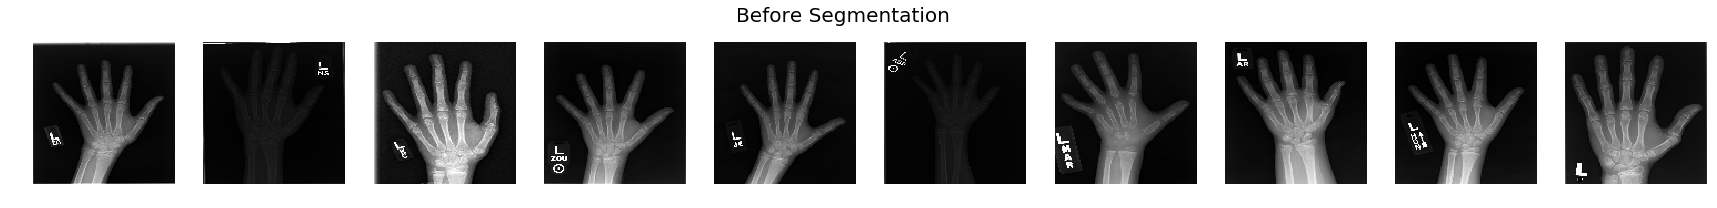

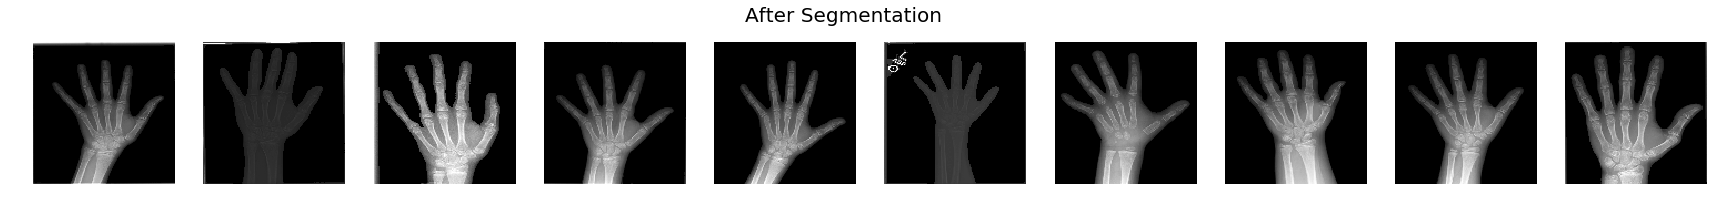

In [9]:
# Load Segmentation model for pre-processing:
# clean handmarks, didgits, etc from the imge to avoid over-fitting
numOfFigs=10
figBefore, axesBefore = plt.subplots(1, numOfFigs, figsize=(30,10))
figAfter, axesAfter = plt.subplots(1, numOfFigs, figsize=(30, 10))

figBefore.suptitle('Before Segmentation', fontsize=20, x=0.5, y=0.65)
figAfter.suptitle('After Segmentation', fontsize=20, x=0.5, y=0.65)

json_file = open('model_segmentation.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
segmentationModel = model_from_json(loaded_model_json)
segmentationModel.load_weights("model_segmentation_weights.h5")
print("Segmentation model loaded")

# Perfrom segmentation on the train set - gives us masks of the train data sets
X_masks = segmentationModel.predict(img_as_ubyte(X_train_after_split))
for n in range(X_masks.shape[0]):
    X_masks[n][X_masks[n] < 0.5] = 0
    X_masks[n][X_masks[n] >= 0.5] = 1
    
# apply the masks on the original images for cleaning
X_train_after_split_seg = X_train_after_split * X_masks

for i in range(0, numOfFigs):
    index = random.randint(0, X_train_after_split.shape[0])    
    axesBefore[i].imshow(X_train_after_split[index,:, :, 0], cmap='gray')
    axesAfter[i].imshow(X_train_after_split_seg[index,:,:,0], cmap='gray')        
    axesBefore[i].axis('off') 
    axesAfter[i].axis('off') 

First try to perform augmetation for all the images with various of augmentations:
* Affine transformation
* Translation only
* Rotation Only
* flip left-right
* flip up-down

Total augmentations double the train set.<br>
<u> Important Note:</u><br>
All augmentations are checked that all coordinates are inside the image, if not it re-agument the image.

Keypoint 0: (112.00000000, 45.00000000) -> (2.00000000, 60.00000000)
Keypoint 1: (60.00000000, 15.00000000) -> (52.00000000, 26.00000000)
Keypoint 2: (56.00000000, 113.00000000) -> (64.00000000, 123.00000000)


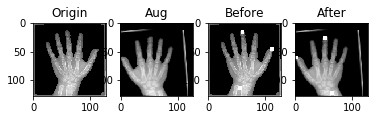

Keypoint 0: (117.00000000, 48.00000000) -> (107.00000000, 69.00000000)
Keypoint 1: (62.00000000, 7.00000000) -> (58.00000000, 20.00000000)
Keypoint 2: (59.00000000, 111.00000000) -> (40.00000000, 123.00000000)


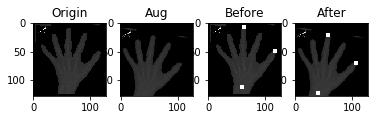

Keypoint 0: (111.00000000, 49.00000000) -> (111.00000000, 49.00000000)
Keypoint 1: (60.00000000, 11.00000000) -> (60.00000000, 11.00000000)
Keypoint 2: (59.00000000, 118.00000000) -> (59.00000000, 118.00000000)


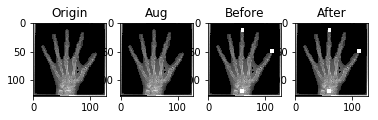

Keypoint 0: (114.00000000, 45.00000000) -> (112.00000000, 78.00000000)
Keypoint 1: (62.00000000, 10.00000000) -> (77.00000000, 26.00000000)
Keypoint 2: (52.00000000, 95.00000000) -> (36.00000000, 100.00000000)


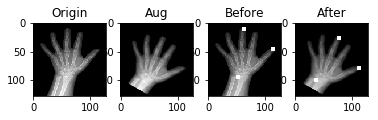

Keypoint 0: (112.00000000, 45.00000000) -> (24.00000000, 63.00000000)
Keypoint 1: (58.00000000, 9.00000000) -> (57.00000000, 7.00000000)
Keypoint 2: (58.00000000, 109.00000000) -> (100.00000000, 98.00000000)


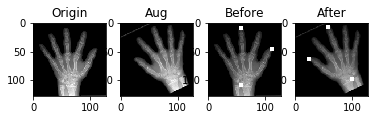

Keypoint 0: (118.00000000, 53.00000000) -> (117.00000000, 49.00000000)
Keypoint 1: (38.00000000, 9.00000000) -> (34.00000000, 11.00000000)
Keypoint 2: (59.00000000, 111.00000000) -> (63.00000000, 111.00000000)


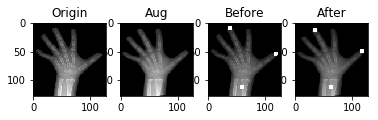

Keypoint 0: (122.00000000, 63.00000000) -> (110.00000000, 78.00000000)
Keypoint 1: (68.00000000, 27.00000000) -> (65.00000000, 31.00000000)
Keypoint 2: (56.00000000, 108.00000000) -> (36.00000000, 108.00000000)


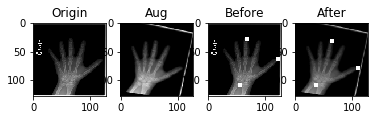

Keypoint 0: (116.00000000, 53.00000000) -> (113.00000000, 61.00000000)
Keypoint 1: (66.00000000, 8.00000000) -> (73.00000000, 115.00000000)
Keypoint 2: (58.00000000, 107.00000000) -> (45.00000000, 20.00000000)


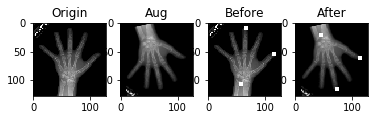

Keypoint 0: (118.00000000, 59.00000000) -> (124.00000000, 66.00000000)
Keypoint 1: (70.00000000, 15.00000000) -> (76.00000000, 22.00000000)
Keypoint 2: (46.00000000, 111.00000000) -> (52.00000000, 118.00000000)


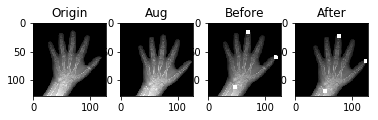

Keypoint 0: (68.00000000, 11.00000000) -> (51.00000000, 6.00000000)
Keypoint 1: (59.00000000, 99.00000000) -> (73.00000000, 91.00000000)
Keypoint 2: (112.00000000, 47.00000000) -> (105.00000000, 24.00000000)


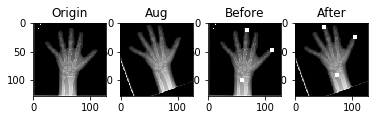

Keypoint 0: (95.00000000, 41.00000000) -> (102.00000000, 58.00000000)
Keypoint 1: (56.00000000, 13.00000000) -> (81.00000000, 15.00000000)
Keypoint 2: (51.00000000, 77.00000000) -> (46.00000000, 70.00000000)


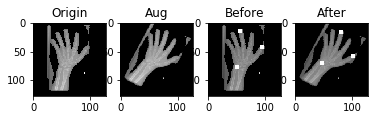

Keypoint 0: (118.00000000, 47.00000000) -> (118.00000000, 47.00000000)
Keypoint 1: (66.00000000, 5.00000000) -> (66.00000000, 5.00000000)
Keypoint 2: (55.00000000, 98.00000000) -> (55.00000000, 98.00000000)


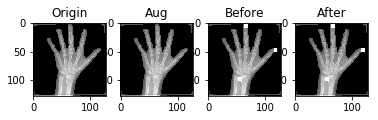

Keypoint 0: (116.00000000, 45.00000000) -> (10.00000000, 55.00000000)
Keypoint 1: (78.00000000, 12.00000000) -> (30.00000000, 101.00000000)
Keypoint 2: (61.00000000, 111.00000000) -> (89.00000000, 20.00000000)


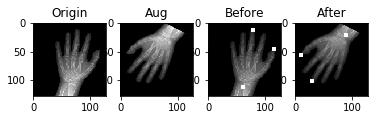

Keypoint 0: (122.00000000, 62.00000000) -> (122.00000000, 62.00000000)
Keypoint 1: (57.00000000, 11.00000000) -> (57.00000000, 11.00000000)
Keypoint 2: (51.00000000, 113.00000000) -> (51.00000000, 113.00000000)


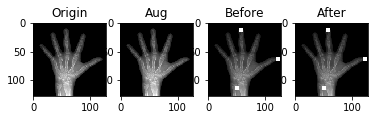

Keypoint 0: (112.00000000, 44.00000000) -> (99.00000000, 66.00000000)
Keypoint 1: (58.00000000, 6.00000000) -> (71.00000000, 6.00000000)
Keypoint 2: (56.00000000, 109.00000000) -> (17.00000000, 94.00000000)


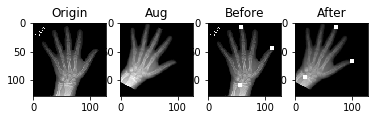

Keypoint 0: (118.00000000, 53.00000000) -> (118.00000000, 53.00000000)
Keypoint 1: (44.00000000, 23.00000000) -> (44.00000000, 23.00000000)
Keypoint 2: (66.00000000, 95.00000000) -> (66.00000000, 95.00000000)


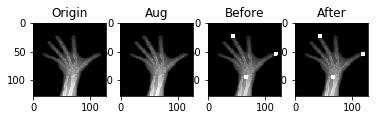

Keypoint 0: (118.00000000, 60.00000000) -> (110.00000000, 60.00000000)
Keypoint 1: (53.00000000, 3.00000000) -> (45.00000000, 3.00000000)
Keypoint 2: (56.00000000, 108.00000000) -> (48.00000000, 108.00000000)


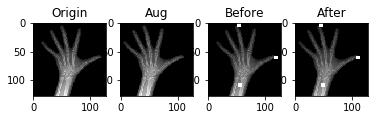

In [36]:
"""Data Augmentation"""
ia.seed(1)
augmented_imgs = np.zeros((len(X_train_after_split_seg), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
augmented_labels = np.zeros((len(X_train_after_split_seg), 6), dtype=np.float32)
border = 3

seq = iaa.Sequential(
[
    iaa.SomeOf((0,5),
   [
    iaa.Affine( translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)},
        rotate=(-10, 10),deterministic=True),
    iaa.Affine( translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, deterministic=True),
    iaa.Affine( rotate=(-30, 30), deterministic=True),
    iaa.Fliplr(0.25),
    iaa.Flipud(0.25)
   ])
], random_order=True)
k = 0
for n, annotate_img_ in enumerate (X_train_after_split_seg):
    bSkip = True
    try:
        while bSkip == True:            
            current_img = X_train_after_split_seg[n]
            keypoints = ia.KeypointsOnImage([
            ia.Keypoint(x=int(Y_train_after_split[n][0]), y=int(Y_train_after_split[n][1])),
            ia.Keypoint(x=int(Y_train_after_split[n][2]), y=int(Y_train_after_split[n][3])),
            ia.Keypoint(x=int(Y_train_after_split[n][4]), y=int(Y_train_after_split[n][5]))
            ], shape=current_img.shape)

            seq_det = seq.to_deterministic()
            image_aug = seq_det.augment_images([current_img])[0]
            keypoints_aug = seq_det.augment_keypoints([keypoints])[0]            
            bSkip = False
            if np.equal(keypoints, keypoints_aug):
                bSkip = True
            for j in range(3):
                if keypoints_aug.keypoints[j].x > (IMG_WIDTH-border) or keypoints_aug.keypoints[j].y > (IMG_HEIGHT-border):
                    bSkip = True
                if keypoints_aug.keypoints[j].x < 0 or keypoints_aug.keypoints[j].y < 0:
                    bSkip = True
                            
        augmented_imgs[k,:,:,:] = image_aug    
        augmented_labels[k,0] = keypoints_aug.keypoints[0].x
        augmented_labels[k,1] = keypoints_aug.keypoints[0].y
        augmented_labels[k,2] = keypoints_aug.keypoints[1].x
        augmented_labels[k,3] = keypoints_aug.keypoints[1].y
        augmented_labels[k,4] = keypoints_aug.keypoints[2].x
        augmented_labels[k,5] = keypoints_aug.keypoints[2].y
        k+=1
        if k % 20 == 0:
            for i in range(len(keypoints.keypoints)):
                before = keypoints.keypoints[i]
                after = keypoints_aug.keypoints[i]
                print("Keypoint %d: (%.8f, %.8f) -> (%.8f, %.8f)" % (
                    i, before.x, before.y, after.x, after.y)
                )

            # image with keypoints before/after augmentation (shown below)
            image_before = keypoints.draw_on_image(current_img,color=1.0, size=7)
            image_after = keypoints_aug.draw_on_image(image_aug,color=1.0, size=7)

            plt.subplot(141),plt.imshow(current_img[:,:,0], cmap='gray'),plt.title('Origin')
            plt.subplot(142),plt.imshow(image_aug[:,:,0], cmap='gray'),plt.title('Aug')
            plt.subplot(143),plt.imshow(image_before[:,:,0], cmap='gray'),plt.title('Before')
            plt.subplot(144),plt.imshow(image_after[:,:,0], cmap='gray'),plt.title('After')
            plt.show()
        
    except:         
        print("error")
        

# Training Phase

In [38]:
batchSize = 32
numEpochs = 15
callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1)]

In [107]:
# Vanilla training
model = createModel()
results = model.fit(X_train_after_split_seg, Y_train_after_split, validation_data=(X_val, Y_val), 
                    batch_size=batchSize, epochs=numEpochs, callbacks=callbacks)

model_json = model.to_json()
with open("model_kp_no_aug.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_kp_weights_no_aug.h5")
print("Saved model to disk")

with open('partVGGNoAug', 'wb') as file_pi:
    pickle.dump(results.history, file_pi)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 128, 128, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      640       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_3 (Activation)    (None, 128, 128, 64)      0         
__________

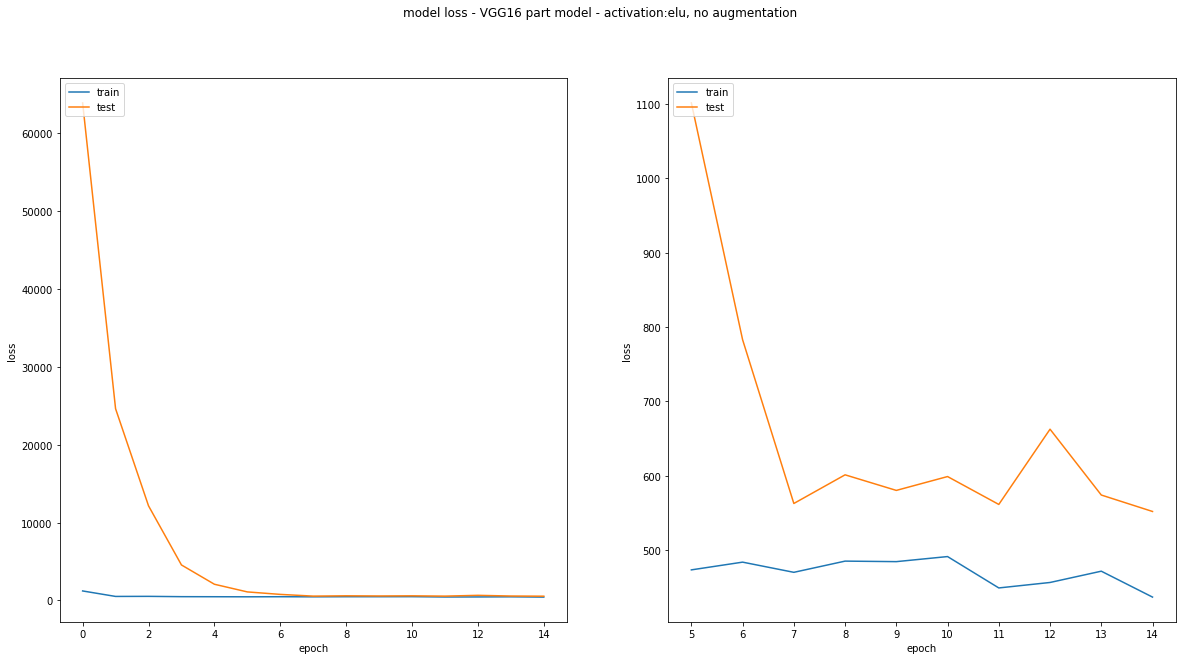

In [116]:
# Plot model results
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].plot(results.history['loss'])
axes[0].plot(results.history['val_loss'])
fig.suptitle('model loss - VGG16 part model - activation:elu, no augmentation')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper left')
axes[1].plot(results.history['loss'][5:])
axes[1].plot(results.history['val_loss'][5:])
plt.xticks(range(0,10), range(5,15))
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='upper left')

In [109]:
# Add Data Augmentation
X_train_aug_split = np.concatenate((X_train_after_split_seg, augmented_imgs), axis=0)
Y_train_aug_split = np.concatenate((Y_train_after_split, augmented_labels), axis=0)

modelAugm = createModel(doPlot=False)
resultsAug = modelAugm.fit(X_train_aug_split, Y_train_aug_split, validation_data=(X_val, Y_val), 
                    batch_size=batchSize, epochs=numEpochs, callbacks=callbacks)

model_json = modelAug.to_json()
with open("model_kp_with_aug.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
modelAug.save_weights("model_kp_weights_with_aug.h5")
print("Saved model to disk")

with open('partVGGWithAug', 'wb') as file_pi:
    pickle.dump(resultsAug.history, file_pi)        

Train on 680 samples, validate on 60 samples
Epoch 1/15
680/680 [==============================] - 452s 665ms/step - loss: 965.4072 - mean_squared_error: 965.4072 - val_loss: 20064.8820 - val_mean_squared_error: 20064.8820
Epoch 2/15
680/680 [==============================] - 451s 663ms/step - loss: 591.4215 - mean_squared_error: 591.4215 - val_loss: 9599.1923 - val_mean_squared_error: 9599.1923
Epoch 3/15
680/680 [==============================] - 453s 666ms/step - loss: 558.8541 - mean_squared_error: 558.8541 - val_loss: 1855.5688 - val_mean_squared_error: 1855.5688
Epoch 4/15
680/680 [==============================] - 448s 659ms/step - loss: 536.0350 - mean_squared_error: 536.0350 - val_loss: 1197.7640 - val_mean_squared_error: 1197.7640
Epoch 5/15
680/680 [==============================] - 448s 659ms/step - loss: 529.4284 - mean_squared_error: 529.4284 - val_loss: 1096.1443 - val_mean_squared_error: 1096.1443
Epoch 6/15
680/680 [==============================] - 453s 666ms/step - l

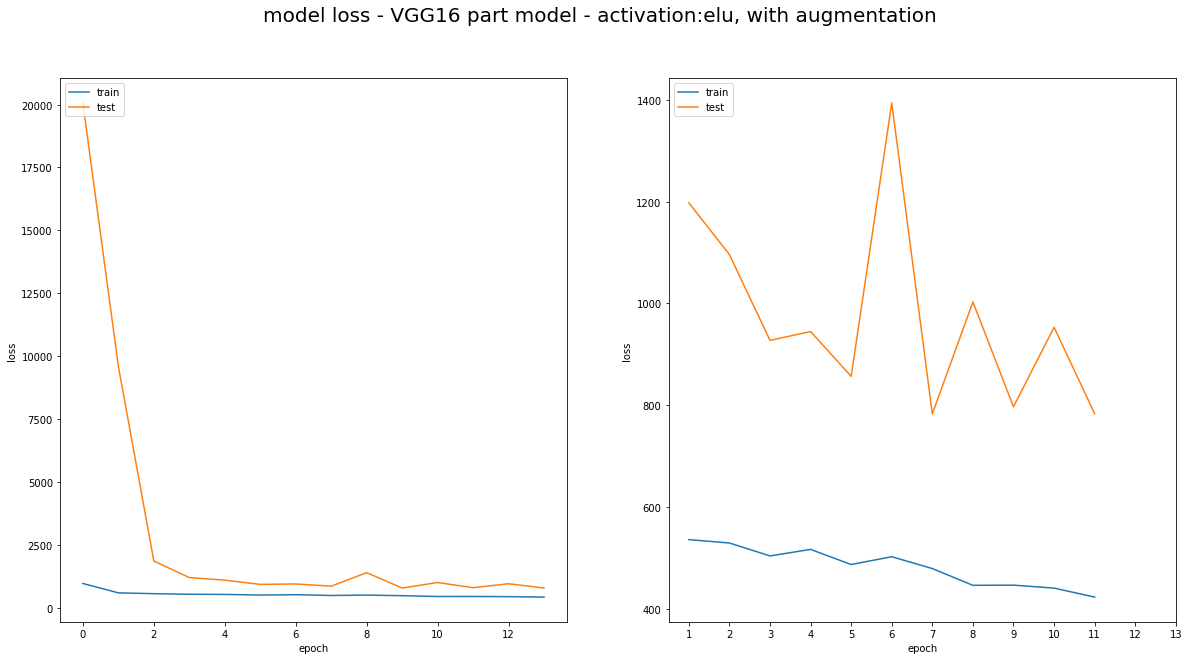

In [117]:
# summarize history for loss
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].plot(resultsAug.history['loss'])
axes[0].plot(resultsAug.history['val_loss'])
fig.suptitle('model loss - VGG16 part model - activation:elu, with augmentation', fontsize=20)
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper left')
axes[1].plot(resultsAug.history['loss'][3:])
axes[1].plot(resultsAug.history['val_loss'][3:])
plt.xticks(range(0,13), range(1,14))
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='upper left')

Here I augment each augmentation type for the whole data set - total 3 times the train set (Flip LR, Rotation and Translation)

Keypoint 0: (112.00000000, 45.00000000) -> (15.00000000, 45.00000000)
Keypoint 1: (58.00000000, 9.00000000) -> (69.00000000, 9.00000000)
Keypoint 2: (58.00000000, 109.00000000) -> (69.00000000, 109.00000000)


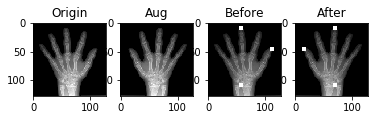

Keypoint 0: (68.00000000, 11.00000000) -> (59.00000000, 11.00000000)
Keypoint 1: (59.00000000, 99.00000000) -> (68.00000000, 99.00000000)
Keypoint 2: (112.00000000, 47.00000000) -> (15.00000000, 47.00000000)


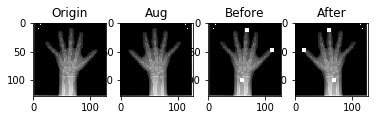

Keypoint 0: (112.00000000, 44.00000000) -> (15.00000000, 44.00000000)
Keypoint 1: (58.00000000, 6.00000000) -> (69.00000000, 6.00000000)
Keypoint 2: (56.00000000, 109.00000000) -> (71.00000000, 109.00000000)


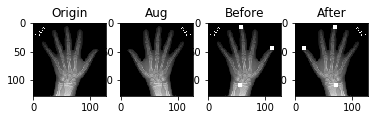

340
Keypoint 0: (112.00000000, 45.00000000) -> (113.00000000, 49.00000000)
Keypoint 1: (58.00000000, 9.00000000) -> (63.00000000, 9.00000000)
Keypoint 2: (58.00000000, 109.00000000) -> (54.00000000, 108.00000000)


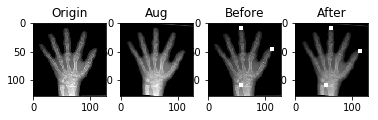

Keypoint 0: (68.00000000, 11.00000000) -> (55.00000000, 12.00000000)
Keypoint 1: (59.00000000, 99.00000000) -> (68.00000000, 99.00000000)
Keypoint 2: (112.00000000, 47.00000000) -> (106.00000000, 35.00000000)


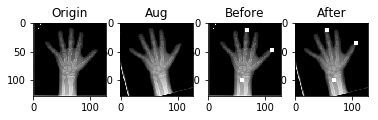

Keypoint 0: (112.00000000, 44.00000000) -> (115.00000000, 52.00000000)
Keypoint 1: (58.00000000, 6.00000000) -> (68.00000000, 6.00000000)
Keypoint 2: (56.00000000, 109.00000000) -> (49.00000000, 107.00000000)


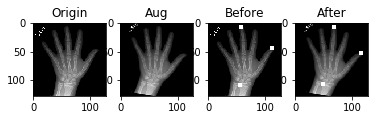

340
Keypoint 0: (112.00000000, 45.00000000) -> (99.00000000, 50.00000000)
Keypoint 1: (58.00000000, 9.00000000) -> (45.00000000, 14.00000000)
Keypoint 2: (58.00000000, 109.00000000) -> (45.00000000, 114.00000000)


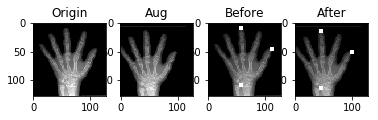

Keypoint 0: (68.00000000, 11.00000000) -> (73.00000000, 23.00000000)
Keypoint 1: (59.00000000, 99.00000000) -> (64.00000000, 111.00000000)
Keypoint 2: (112.00000000, 47.00000000) -> (117.00000000, 59.00000000)


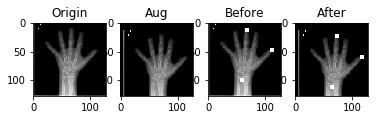

Keypoint 0: (112.00000000, 44.00000000) -> (108.00000000, 40.00000000)
Keypoint 1: (58.00000000, 6.00000000) -> (54.00000000, 2.00000000)
Keypoint 2: (56.00000000, 109.00000000) -> (52.00000000, 105.00000000)


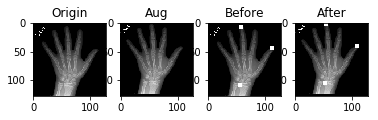

340
Train on 1360 samples, validate on 60 samples
Epoch 1/15
1360/1360 [==============================] - 886s 651ms/step - loss: 775.4816 - mean_squared_error: 775.4816 - val_loss: 6343.6831 - val_mean_squared_error: 6343.6831
Epoch 2/15
1360/1360 [==============================] - 889s 654ms/step - loss: 557.0527 - mean_squared_error: 557.0527 - val_loss: 1166.6031 - val_mean_squared_error: 1166.6031
Epoch 3/15
1360/1360 [==============================] - 884s 650ms/step - loss: 541.6306 - mean_squared_error: 541.6306 - val_loss: 712.2609 - val_mean_squared_error: 712.2609
Epoch 4/15
1360/1360 [==============================] - 886s 651ms/step - loss: 527.5788 - mean_squared_error: 527.5788 - val_loss: 809.7810 - val_mean_squared_error: 809.7810
Epoch 5/15
1360/1360 [==============================] - 881s 648ms/step - loss: 539.3041 - mean_squared_error: 539.3041 - val_loss: 699.0325 - val_mean_squared_error: 699.0325
Epoch 6/15
1360/1360 [==============================] - 885s 651ms

In [111]:
# Data Augmentation #2
ia.seed(1)
trainSize = len(X_train_after_split_seg)
border = 3

seqFlip = iaa.Sequential(
[            
    iaa.Fliplr(1.0)    
], random_order=True)

seqRot = iaa.Sequential(
[    
    iaa.Affine( rotate=(-20, 20), deterministic=True)    
], random_order=True)
seqTrans = iaa.Sequential(
[    
    iaa.Affine( translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, deterministic=True),    
], random_order=True)

seqList = [seqFlip, seqRot, seqTrans]

augmented_imgs_total = np.zeros((len(seqList) * trainSize, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
augmented_labels_total = np.zeros((len(seqList) * trainSize, 6), dtype=np.float32)

def createAugmentation(seq, originalImages=X_train_after_split_seg, originalKeyPoints=Y_train_after_split):
    augmented_imgs = np.zeros((len(originalImages), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    augmented_labels = np.zeros((len(originalKeyPoints), 6), dtype=np.float32)
    k = 0
    for n, annotate_img_ in enumerate (originalImages):
        bSkip = True
        try:            
            while bSkip == True:            
                current_img = originalImages[n]
                keypoints = ia.KeypointsOnImage([
                ia.Keypoint(x=int(originalKeyPoints[n][0]), y=int(originalKeyPoints[n][1])),
                ia.Keypoint(x=int(originalKeyPoints[n][2]), y=int(originalKeyPoints[n][3])),
                ia.Keypoint(x=int(originalKeyPoints[n][4]), y=int(originalKeyPoints[n][5]))
                ], shape=current_img.shape)

                seq_det = seq.to_deterministic()            
                image_aug = seq_det.augment_images([current_img])[0]
                keypoints_aug = seq_det.augment_keypoints([keypoints])[0]            
                bSkip = False
                if np.equal(keypoints, keypoints_aug):
                    bSkip = True
                for j in range(3):
                    if keypoints_aug.keypoints[j].x > (IMG_WIDTH-border) or keypoints_aug.keypoints[j].y > (IMG_HEIGHT-border):
                        bSkip = True
                    if keypoints_aug.keypoints[j].x < 0 or keypoints_aug.keypoints[j].y < 0:
                        bSkip = True

            augmented_imgs[k,:,:,:] = image_aug    
            augmented_labels[k,0] = keypoints_aug.keypoints[0].x
            augmented_labels[k,1] = keypoints_aug.keypoints[0].y
            augmented_labels[k,2] = keypoints_aug.keypoints[1].x
            augmented_labels[k,3] = keypoints_aug.keypoints[1].y
            augmented_labels[k,4] = keypoints_aug.keypoints[2].x
            augmented_labels[k,5] = keypoints_aug.keypoints[2].y
            k+=1
            if k % 100 == 0:
                for i in range(len(keypoints.keypoints)):
                    before = keypoints.keypoints[i]
                    after = keypoints_aug.keypoints[i]
                    print("Keypoint %d: (%.8f, %.8f) -> (%.8f, %.8f)" % (
                        i, before.x, before.y, after.x, after.y)
                    )

                # image with keypoints before/after augmentation (shown below)
                image_before = keypoints.draw_on_image(current_img,color=1.0, size=7)
                image_after = keypoints_aug.draw_on_image(image_aug,color=1.0, size=7)

                plt.subplot(141),plt.imshow(current_img[:,:,0], cmap='gray'),plt.title('Origin')
                plt.subplot(142),plt.imshow(image_aug[:,:,0], cmap='gray'),plt.title('Aug')
                plt.subplot(143),plt.imshow(image_before[:,:,0], cmap='gray'),plt.title('Before')
                plt.subplot(144),plt.imshow(image_after[:,:,0], cmap='gray'),plt.title('After')
                plt.show()

        except:         
            print("error")

    print(k)
    return augmented_imgs, augmented_labels


augmented_imgs_total[:trainSize,:,:,:], augmented_labels_total[:trainSize] = createAugmentation(seqFlip, X_train_after_split_seg, Y_train_after_split)
augmented_imgs_total[trainSize:2*trainSize,:,:,:], augmented_labels_total[trainSize:2*trainSize] = createAugmentation(seqRot, X_train_after_split_seg, Y_train_after_split)
augmented_imgs_total[2*trainSize:3*trainSize,:,:,:], augmented_labels_total[2*trainSize:3*trainSize] = createAugmentation(seqTrans, X_train_after_split_seg, Y_train_after_split)

# Add Data Augmentation
X_train_aug2_split = np.concatenate((X_train_after_split_seg, augmented_imgs_total), axis=0)
Y_train_aug2_split = np.concatenate((Y_train_after_split, augmented_labels_total), axis=0)

modelAugm2 = createModel(doPlot=False)
resultsAug2 = modelAugm2.fit(X_train_aug2_split, Y_train_aug2_split, validation_data=(X_val, Y_val), 
                    batch_size=batchSize, epochs=numEpochs, callbacks=callbacks)

model_json = modelAug2.to_json()
with open("model_kp_with_aug2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_kp_weights_with_aug2.h5")
print("Saved model to disk")

with open('partVGGWithAug2', 'wb') as file_pi:
    pickle.dump(resultsAug2.history, file_pi)    

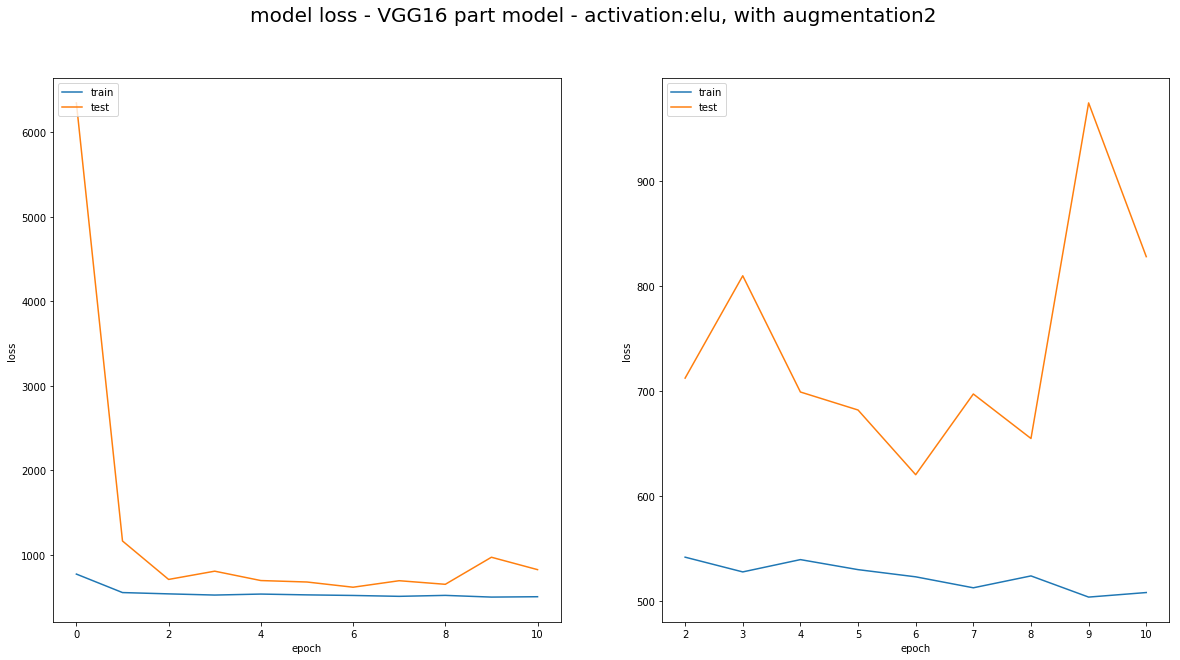

In [119]:
# summarize history for loss
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].plot(resultsAug2.history['loss'])
axes[0].plot(resultsAug2.history['val_loss'])
fig.suptitle('model loss - VGG16 part model - activation:elu, with augmentation2', fontsize=20)
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper left')
axes[1].plot(resultsAug2.history['loss'][2:])
axes[1].plot(resultsAug2.history['val_loss'][2:])
plt.xticks(range(0,9), range(2,11))
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='upper left')

Transfer Learning - Take only first 3 blocks of VGG (more generic features) and add regressor head to it.
<br> since the data set is fairly small, transfer learning after the first layers can help reducing over-fitting.

In [121]:
# Fine Tuning of VGG16 with ImageNet weights
from keras.applications import VGG16

X_trainVGG = np.tile(X_train_aug2_split, (1,1,1,3))
Y_trainVGG = np.tile(Y_train_aug2_split, (1,3))
X_valVGG = np.tile(X_val, (1,1,1,3))
Y_valVGG = np.tile(Y_val, (1,3))

print(X_trainVGG.shape)
print(Y_trainVGG.shape)
print(X_valVGG.shape)
print(Y_valVGG.shape)

conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# remove layers until the 3rd block
for i in range(0,8):
    conv_base.layers.pop()

conv_base.trainable = False

modelFineTuning = Sequential()
modelFineTuning.add(conv_base)
modelFineTuning.add(Flatten())
modelFineTuning.add(Dropout(0.5))
modelFineTuning.add(Dense(6*3))

modelFineTuning.summary()
modelFineTuning.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

resultsFT = modelFineTuning.fit(X_trainVGG, Y_trainVGG, validation_data=(X_valVGG, Y_valVGG), 
                    batch_size=batchSize, epochs=numEpochs*2, callbacks=callbacks)# summarize history for loss

(1360, 128, 128, 3)
(1360, 18)
(60, 128, 128, 3)
(60, 18)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         1735488   
_________________________________________________________________
flatten_16 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 18)                147474    
Total params: 1,882,962
Trainable params: 147,474
Non-trainable params: 1,735,488
_________________________________________________________________
Train on 1360 samples, validate on 60 samples
Epoch 1/30
1360/1360 [==============================] - 188s 138ms/step - loss: 2897.7532 - mean_squared_error: 2897.7532 - val_loss: 1685.4240 - val_mean

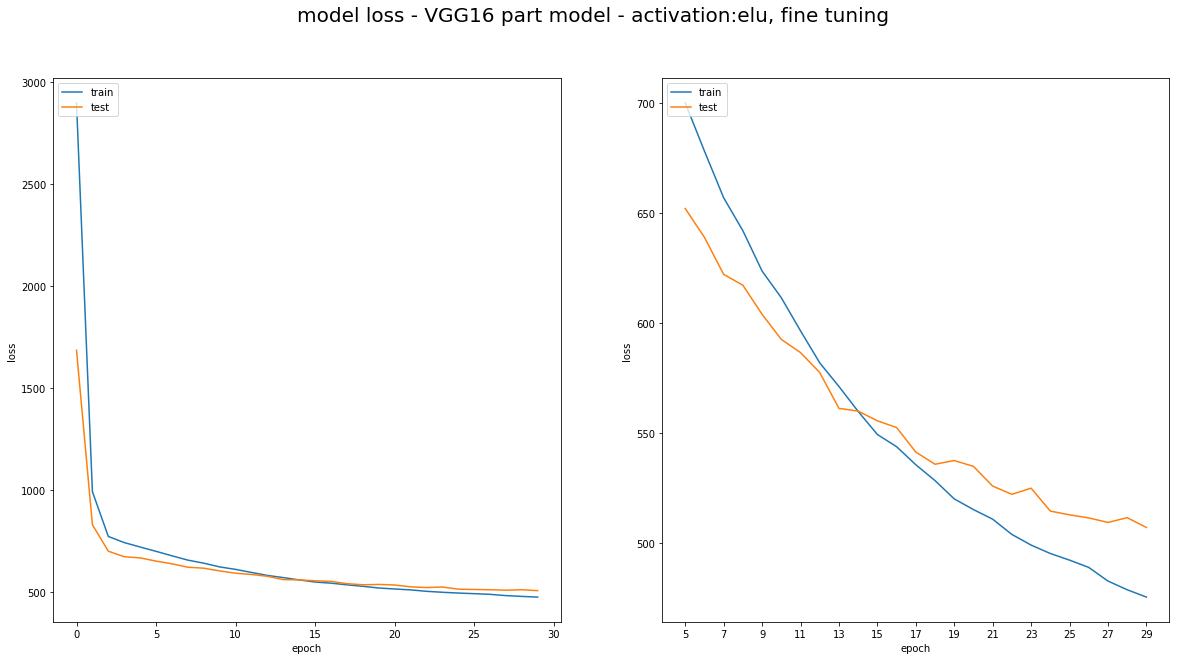

In [122]:
# summarize history for loss
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].plot(resultsFT.history['loss'])
axes[0].plot(resultsFT.history['val_loss'])
fig.suptitle('model loss - VGG16 part model - activation:elu, fine tuning', fontsize=20)
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper left')
axes[1].plot(resultsFT.history['loss'][5:])
axes[1].plot(resultsFT.history['val_loss'][5:])
plt.xticks(range(0,25,2), range(5,30,2))
axes[1].set_ylabel('loss') 
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='upper left')

# Inference Phase + Geometric Transformation

In [123]:
test_files = os.listdir(TEST_PATH)
test_imgs = np.zeros((len(test_files), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.float32)
for n, img in enumerate(test_files):    
    fullPath = os.path.join(TEST_PATH, img)
    t_img = np.expand_dims(imread(fullPath)[:,:], axis=2)        
    t_img = resize(t_img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)    
    t_img /= 255
    t_img = np.expand_dims(t_img, axis=0)
    test_imgs[n] = t_img

# test_imgs -= meanImg
X_testVGG = np.tile(test_imgs, (1,1,1,3))
yPred = modelFineTuning.predict(X_testVGG)

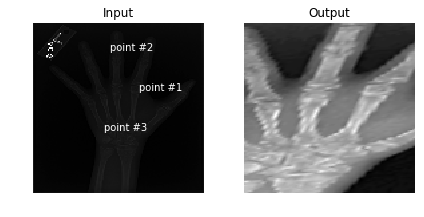

In [124]:
imgIndex = 0
refPts = np.concatenate([[110, 50], [60, 10], [0, 100]], axis=0).astype(np.float32)
refPts = refPts.reshape((3,2))

curPts = np.concatenate([[yPred[imgIndex][0], yPred[imgIndex][1]], [yPred[imgIndex][2], yPred[imgIndex][3]],
                         [yPred[imgIndex][4], yPred[imgIndex][5]]], axis=0).astype(np.float32)
curPts = curPts.reshape((3,2))

M = cv2.getAffineTransform(curPts, refPts)        
dst = cv2.warpAffine(test_imgs[imgIndex],M,(IMG_WIDTH,IMG_HEIGHT))        

plt.subplot(121),plt.imshow(test_imgs[imgIndex,:,:,0], cmap='gray'),plt.title('Input')
plt.annotate('point #1', (yPred[imgIndex][0], yPred[imgIndex][1]), color='white')
plt.annotate('point #2', (yPred[imgIndex][2], yPred[imgIndex][3]), color='white')
plt.annotate('point #3', (yPred[imgIndex][4], yPred[imgIndex][5]), color='white')
plt.axis('off')
plt.subplot(122),plt.imshow(dst, cmap='gray'),plt.title('Output')
plt.axis('off')
plt.tight_layout()